# 1. Quick Start 简易入门
Prophet 遵循 **sklearn** 库建模的应用程序接口。我们创建了一个 Prophet 类的实例，其中使用了“拟合模型” **fit** 和“预测” **predict** 方法。

Prophet 的输入量往往是一个包含两列的数据框：**ds** 和 **y** 。**ds** 列必须包含日期（YYYY-MM-DD）或者是具体的时间点（YYYY-MM-DD HH:MM:SS）。 **y** 列必须是数值变量，表示我们希望去预测的量。

下面实例中使用的是 [佩顿 · 曼宁的维基百科主页](https://en.wikipedia.org/wiki/Peyton_Manning) 每日访问量的时间序列数据（**2007/12/10 - 2016/01/20**）。我们使用 R 中的 [Wikipediatrend](https://cran.r-project.org/web/packages/wikipediatrend/index.html) 包获取该数据集。这个数据集具有多季节周期性、不断变化的增长率和可以拟合特定日期（例如佩顿 · 曼宁的决赛和超级碗）的情况等 Prophet 适用的性质，因此可以作为一个不错的例子。（*注：佩顿 · 曼宁为前美式橄榄球四分卫*）

首先，我们导入数据，该数据已经做过了log处理（即，做过df['y'] = np.log(df['y'])操作）。

In [1]:
import pandas as pd
from fbprophet import Prophet
df = pd.read_csv('examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007/12/10,9.590761
1,2007/12/11,8.519590
2,2007/12/12,8.183677
3,2007/12/13,8.072467
4,2007/12/14,7.893572


通过对一个 Prophet 对象进行实例化来拟合模型，**任何影响预测过程的设置都将在构造模型时被指定**。接下来，就可以使用 fit 方法代入历史数据集来拟合模型，拟合过程应当花费 1 - 5 秒。

In [2]:
# 拟合模型
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\PC-00001\Miniconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



预测过程则需要建立在包含日期 **ds** 列的数据框基础上。通过使用辅助的方法 **Prophet.make_future_dataframe** 来将未来的日期扩展指定的天数，得到一个合规的数据框。**默认情况下，这样做会自动包含历史数据的日期，因此我们也可以用来查看模型对于历史数据的拟合效果**。

future数据集比原数据集往后多了一年的日期，之前日期是到2016-01-20的，所以这里用了一个tail()函数查看尾部

In [3]:
# 构建待预测日期数据框，periods = 365 代表除历史数据的日期外再往后推 365 天
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


**predict** 方法将会对每一行未来 **future** 日期得到一个预测值（称为 **yhat** ）。如果你传入了历史数据的日期，它将会提供样本的模型拟合值。预测 **forecast** 创建的对象应当是一个新的数据框，其中包含一列预测值 **yhat** ，以及成分的分析和置信区间。

In [4]:
# 预测数据集
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.211273,7.458141,8.926799
3266,2017-01-16,8.536290,7.832873,9.272192
3267,2017-01-17,8.323693,7.584379,9.027640
3268,2017-01-18,8.156351,7.458842,8.882523
3269,2017-01-19,8.168285,7.406699,8.934088


通过 **Prophet.plot** 方法传入预测得到的数据框，可以对预测的效果进行绘图。

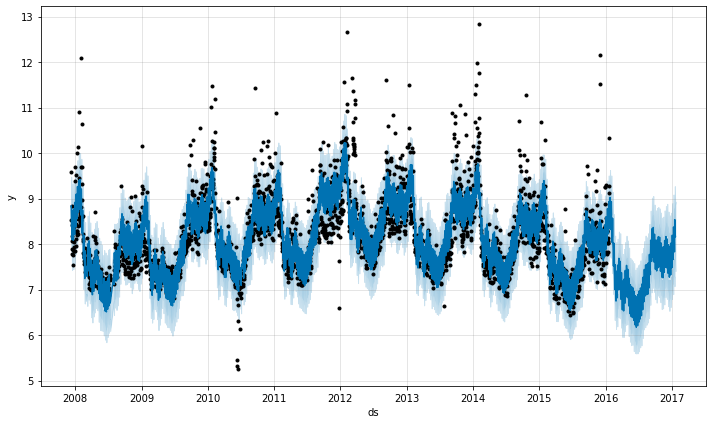

In [8]:
# 展示预测结果
# %matplotlib inline
pd.plotting.register_matplotlib_converters()
figure1 = m.plot(forecast)

如果想查看预测的成分分析，可以使用 **Prophet.plot_components** 方法。默认情况下，将展示趋势、时间序列的年度季节性和周季节性。如果之前包含了节假日，也会展示出来。

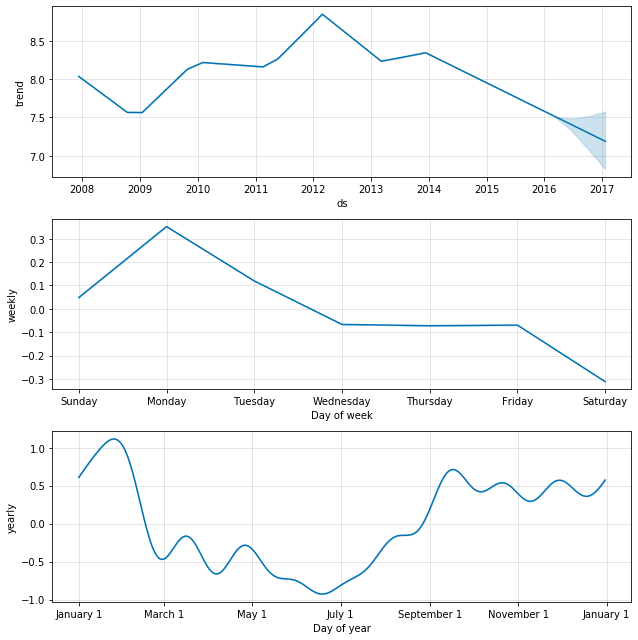

In [9]:
# 预测的成分分析绘图，展示预测中的趋势、周效应和年度效应
figure2 = m.plot_components(forecast)

**注： 一个很核心的问题是我们应该怎么样理解上图的3个子图。**通过对forecast这个Dataframe分析我们就可以得到结论。

我们先看下forecast都有哪些列。

In [7]:
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


通过对数据的分析，我们就可以知道：

①图1是根据trend画出来的，图2是根据weekly画出来的，图3是根据yearly画出来的。

②因为是加法模型，
有：forecast['additive_terms'] = forecast['weekly'] + forecast['yearly']；
有：forecast['yhat']  = forecast['trend'] +  forecast['additive_terms'] 。
因此：**forecast['yhat']  = forecast['trend'] +forecast['weekly'] + forecast['yearly']。**

如果有节假日因素，那么就会有
forecast['yhat']  = forecast['trend'] +forecast['weekly'] + forecast['yearly'] + forecast['holidays']。

在第四部分，我们会讲到节假日因素，对于那些是节假日的天数，forecast['holidays']才会有值，不是节假日的天数，forecast['holidays']为0。

③因为是加法模型，'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper'这3列为空。

因此，基于上面的分析，weekly中的Monday为0.3的意思就是，在trend的基础上，加0.3；Saturday为-0.3的意思就是，在trend的基础上，减0.3。因此，这条线的高低也在一定程度上反应了“销量的趋势“。

**注：许多方法的细节可以通过help(Prophet) 或者 help(Prophet.fit) 来获得。**